Benjamin Katz <br>
May 8th<br>
Movie Senitment anaylasis<br>
Final week

The first Model(found on this colab) performed the best, this was not surprising, the bag of words model preserves a lot of information. it tells you exactly what words are in the reveiw but not neccesarily the order that the appear in(like model 3 LSTM). While the metrics for the first model were the best it was constantly failing to execute because of how enormous the vectors were. 
<br><br>
Model 2 which takes the average of the word vectors also performs ok but not as good as this first model. It is a much smaller model and all the information for a reveiw is packed into a 100 element vector. The first model uses about 10,00 elements to represent a reveiw! because of this it is much smaller and runs much faster.
<br><br>
Model 3 uses a LSTM so it also uses a lot of vector space. 100 element vecotr for every word so it also performs fairly slowly and still performs very slightly worse than both models.

Part 2: https://colab.research.google.com/drive/1pOKPoCYUbdzr4Vu6V7CNEIzxbB5-yCHW?usp=sharing
<br>
Part 3:https://colab.research.google.com/drive/1Ym7PLTUzygkSjZ_OM11tk7aJ_EBw6QFy?usp=sharing

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pandas as pd

from gensim.models import Word2Vec
#Download the data like was given in the colab
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#seperate out testing and training data
imdb, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)
train_data, test_data = imdb['train'], imdb['test']

In [ ]:
train_df = tfds.as_dataframe(imdb['train'], info)


In [ ]:
#look at the training data
train_df.head()

,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...
3,1,b'This is the kind of film for a snowy Sunday ...
4,1,"b'As others have mentioned, all the women that..."


In [ ]:
#Create the dictionary
#first lets count how often the words appear so that we can only reserve a spot 
#in the one hot encoding vector for common words
import string
#creat a set that we will use later
dictionary = set(("the"))
#create a dictionary to see how often the word apears
frequency = {}
#look at every reveiw and tokenize the reveiw. lowercase everything and seperate 
#by space and remove words that are too common and remove punctuation
for reveiw in train_df.text:
  #split on space and lowercase all words
  reveiw = str(reveiw)
  tokens = word_tokenize(reveiw)
  tokens = [w.lower() for w in tokens]
  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  #remove stop words aka uncommon words
  stop_words = set(stopwords.words('english'))
  words = [w for w in stripped if not w in stop_words]
  #count how often these words come up, when we include the obscure words we run
  #out of memory
  for word in words:
    frequency[word] = frequency[word] + 1 if word in frequency else 1
    #dictionary.add(word)


In [ ]:
#If a word is not common, disgard it. Takes up too much space and it is hard to
#learn from if there is not enough context
for key in frequency:
  if (frequency[key]>30):
    #if it is common add it to our vocab
    dictionary.add(key)
print(len(dictionary))

9908


In [ ]:
#set the vector with the count so we know what position every word is in
vector_ordering  = {}
for count, ele in enumerate(dictionary):
  vector_ordering[ele] = count
print(vector_ordering)

{'': 0, 'causes': 1, 'banned': 2, 'bloodshed': 3, 'stripped': 4, 'drive': 5, 'awfully': 6, 'madman': 7, 'wave': 8, 'could': 9, 'ebert': 10, 'bombed': 11, 'coffee': 12, 'competing': 13, 'vile': 14, 'managing': 15, 'filmography': 16, 'kristofferson': 17, 'underneath': 18, 'boyfriend': 19, 'marred': 20, 'subtitled': 21, 'awesome': 22, 'milo': 23, 'paltrow': 24, 'sells': 25, 'creepy': 26, 'jackman': 27, 'bother': 28, 'fuss': 29, 'moon': 30, 'prank': 31, 'still': 32, 'ggirl': 33, 'fleeing': 34, 'alienation': 35, 'monday': 36, 'addicted': 37, 'tactics': 38, 'colman': 39, 'appears': 40, 'mtv': 41, 'clarence': 42, 'talking': 43, 'blink': 44, 'gandolfini': 45, 'draft': 46, 'slug': 47, 'byes': 48, 'macbeth': 49, 'dominick': 50, 'interested': 51, 'maturity': 52, 'workers': 53, 'print': 54, 'accused': 55, 'weapon': 56, 'objective': 57, 'judgment': 58, 'abound': 59, 'entry': 60, 'eccentric': 61, 'circa': 62, 'awareness': 63, 'griffith': 64, 'enterprise': 65, 'claustrophobic': 66, 'isolation': 67, '

In [ ]:
#Create the vectors
import string
vector_column = []
for review in train_df.text:
  #Do the same tokenization as before so that we can put make every reveiw(sorry dry)
  #a 1 hot coded vector with the words of the reveiw
  review = str(review)
  #tokenize and lowercase
  tokens = word_tokenize(review)
  tokens = [w.lower() for w in tokens]
  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  #remove stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in stripped if not w in stop_words]
  #add a column to the database of the tokenized words
  vector_column.append(words)
  

In [ ]:
#add to dataframe
train_df['tokens'] = vector_column
train_df.head()

,label,text,tokens
0,0,"b""This was an absolutely terrible movie. Don't...","[b, , absolutely, terrible, movie, , nt, lured..."
1,0,b'I have been known to fall asleep during film...,"[b, , known, fall, asleep, films, , usually, d..."
2,0,b'Mann photographs the Alberta Rocky Mountains...,"[bmann, photographs, alberta, rocky, mountains..."
3,1,b'This is the kind of film for a snowy Sunday ...,"[bthis, kind, film, snowy, sunday, afternoon, ..."
4,1,"b'As others have mentioned, all the women that...","[bas, others, mentioned, , women, go, nude, fi..."


In [ ]:
#do the one hot encoding
encoding_column = []
for token_array in train_df.tokens:
  #create empty vector
  review_vector = np.zeros(len(vector_ordering))
  tokens = token_array
  #go through the reveiw token by token
  for token in tokens:
    #if the token is something we have in the vocab
    if(token in vector_ordering):
      #change the zero to a one for the vector
      review_vector[vector_ordering[token]] = 1
  #add the encoded vecor as a part of the data frame
  encoding_column.append(review_vector)

In [ ]:
#set the dataframe to add the encoding
train_df['encoding'] = encoding_column

In [ ]:
print(len(vector_ordering))
print(len(train_df.label))
train_df.head()

9908
25000


,label,text,tokens,encoding
0,0,"b""This was an absolutely terrible movie. Don't...","[b, , absolutely, terrible, movie, , nt, lured...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,b'I have been known to fall asleep during film...,"[b, , known, fall, asleep, films, , usually, d...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,b'Mann photographs the Alberta Rocky Mountains...,"[bmann, photographs, alberta, rocky, mountains...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,b'This is the kind of film for a snowy Sunday ...,"[bthis, kind, film, snowy, sunday, afternoon, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,"b'As others have mentioned, all the women that...","[bas, others, mentioned, , women, go, nude, fi...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
#set x_train to be an array of these sparse vectors
X_train = np.array(encoding_column)
#set y train to be the labeled data
Y_train = np.asarray(train_df['label']).astype(np.float32)


In [ ]:
print(X_train.shape)
print(X_train)

(25000, 9908)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras
import matplotlib.pyplot as plt
#get started with the neural net
import tensorflow as tf

#The input is a sparse one hot encoded vecotr
number_of_features = len(encoding_column[0])
print(number_of_features)
model = Sequential()

#Tell the model we want to use the relu function to map our data
#Add a layer of 500 nodes and maintain the activation as relu
model.add(Dense(500, activation = 'relu'))
#add the output layer with 2 outputs representing 0 or 1
#The activation must be sigmoid because this is a classification model
model.add(Dense(1, activation = 'sigmoid'))


#Set gradient desent to a loss function of binary cross entrapy
model.compile(loss='binary_crossentropy', metrics = ['accuracy'])
#actually perform the gradient desent over 5 epochs with a batch_size of 200 on the training data
#too many and we risk overfitting

history = model.fit(X_train, Y_train, epochs=5, batch_size = 200)


9908
Epoch 1/5
125/125 [==============================] - 15s 115ms/step - loss: 0.3488 - accuracy: 0.8531
Epoch 2/5
125/125 [==============================] - 14s 116ms/step - loss: 0.2143 - accuracy: 0.9156
Epoch 3/5
125/125 [==============================] - 17s 133ms/step - loss: 0.1555 - accuracy: 0.9424
Epoch 4/5
125/125 [==============================] - 16s 132ms/step - loss: 0.1083 - accuracy: 0.9618
Epoch 5/5
125/125 [==============================] - 15s 118ms/step - loss: 0.0655 - accuracy: 0.9816


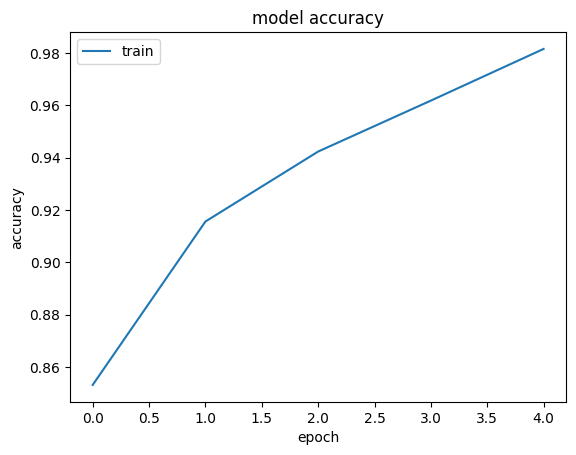

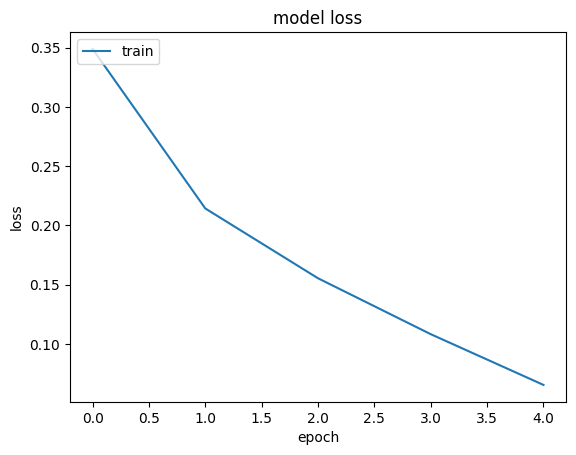

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_df = tfds.as_dataframe(imdb['test'], info)

In [ ]:
#Do the same tokenization for the testing data
import string
vector_column = []
for review in test_df.text:
  review = str(review)
  tokens = word_tokenize(review)
  #lowercase everything
  tokens = [w.lower() for w in tokens]
  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  #remove stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in stripped if not w in stop_words]
  #add these words to a vector
  vector_column.append(words)

test_df['tokens'] = vector_column
test_df.head()

,label,text,tokens
0,1,"b""There are films that make careers. For Georg...","[b, , films, make, careers, , george, romero, ..."
1,1,"b""A blackly comic tale of a down-trodden pries...","[b, , blackly, comic, tale, downtrodden, pries..."
2,0,"b'Scary Movie 1-4, Epic Movie, Date Movie, Mee...","[bscary, movie, 14, , epic, movie, , date, mov..."
3,0,b'Poor Shirley MacLaine tries hard to lend som...,"[bpoor, shirley, maclaine, tries, hard, lend, ..."
4,1,b'As a former Erasmus student I enjoyed this f...,"[bas, former, erasmus, student, enjoyed, film,..."


In [ ]:
#perform the encoding for the test data
encoding_column = []
for token_array in test_df.tokens:
  #create zero vectors
  review_vector = np.zeros(len(vector_ordering))
  tokens = token_array
  #go through the tokens
  for token in tokens:
    #if its a token we recognize we can on ehot encode it
    if(token in vector_ordering):
      #one hot encode it
      review_vector[vector_ordering[token]] = 1
  encoding_column.append(review_vector)

In [ ]:
#set the test data to be what we just one hot encoded
X_test = np.array(encoding_column)
Y_test = np.asarray(test_df['label']).astype(np.float32)
print(X_test)
print(Y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[1. 1. 0. ... 0. 1. 1.]


In [ ]:
print(Y_test.shape)
print(X_test.shape)

(25000,)
(25000, 9908)


In [ ]:
#perform the test on only 400 test points because we do not have enough ram
test_results = model.evaluate(X_test[:400], Y_test[:400])
print(test_results)

13/13 [==============================] - 1s 24ms/step - loss: 0.4688 - accuracy: 0.8600
[0.46881264448165894, 0.8600000143051147]


In [ ]:
#Make predictions for the test dataset
y_prediction = model.predict(X_test[:400])
#Convert back to classificatio by rounding
y_prediction_class = np.round(y_prediction)

13/13 [==============================] - 0s 14ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, recall_score, precision_score, accuracy_score

# The mean squared error see more in the write up
print("Mean squared error: %.2f" % mean_squared_error(Y_test[:400], y_prediction_class))
# The recall
print("Recall: %.2f" % recall_score(Y_test[:400], y_prediction_class))
# The precision
print("Precision: %.2f" % precision_score(Y_test[:400], y_prediction_class))
# The accuracy
print("Accuracy: %.2f" % accuracy_score(Y_test[:400], y_prediction_class))

Mean squared error: 0.14
Recall: 0.89
Precision: 0.84
Accuracy: 0.86


Part two and three are linked at the top